In [174]:
import sys
from pathlib import Path

project_root = Path().resolve().parent
sys.path.insert(0, str(project_root / 'src'))

print(f"Project root: {project_root}")
print(f"Python path updated to include: {project_root / 'src'}")

Project root: D:\Projects\Acads\CSC172\CSC172-AssociationMining-Tigley
Python path updated to include: D:\Projects\Acads\CSC172\CSC172-AssociationMining-Tigley\src


In [175]:
import pandas as pd
import ast
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [193]:
df_transactions = pd.read_csv('../datasets/formatted/transactions.csv')
df_transactions['tags'] = df_transactions['tags'].apply(ast.literal_eval)

transactions = df_transactions['tags'].tolist()

te = TransactionEncoder()
df_onehot = pd.DataFrame(
    te.fit(transactions).transform(transactions),
    columns=te.columns_
)


print(df_onehot.head())
print("Total tags (columns):", df_onehot.shape[1])


   1930s  1970s  1980s  absurd  action  adaptation  adapted from play  \
0  False  False  False   False   False       False              False   
1  False  False  False   False   False       False              False   
2  False  False  False   False   False       False              False   
3  False  False  False   False   False       False              False   
4  False  False  False   False   False       False              False   

   adultery  adventure  affectionate  ...  visceral  visual  \
0     False      False         False  ...     False   False   
1     False       True         False  ...     False   False   
2     False      False         False  ...     False   False   
3      True      False         False  ...     False   False   
4     False      False         False  ...     False   False   

   visually appealing    war  wartime  wedding  whimsical  witty  women  \
0               False  False    False    False      False  False  False   
1               False  False    

In [196]:
import time

print("Mining frequent itemsets...")
start = time.time()

frequent_itemsets = apriori(
    df_onehot,
    min_support=0.005,    # Further lowered to capture more diverse patterns
    max_len=5,            # Increased to allow larger itemsets
    use_colnames=True,
    verbose=1
)

elapsed = time.time() - start
print(f" Found {len(frequent_itemsets)} frequent itemsets in {elapsed:.2f}s")

print("\nItemset size distribution:")
for length in range(1, 6):
    count = len(frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x) == length)])
    print(f"  Length {length}: {count} itemsets")

print("\nGenerating association rules...")
start = time.time()

rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.2,
)

elapsed = time.time() - start
print(f" Generated {len(rules)} rules in {elapsed:.2f}s")

# Analyze rule complexity
rules['antecedent_len'] = rules['antecedents'].apply(lambda x: len(x))
rules['consequent_len'] = rules['consequents'].apply(lambda x: len(x))

# Show multi-consequent rules specifically
multi_consequent = rules[rules['consequent_len'] > 1].nlargest(10, 'confidence')
if len(multi_consequent) > 0:
    print(f"\n Top multi-consequent rules:")
    for idx, row in multi_consequent.iterrows():
        ant = ', '.join(list(row['antecedents']))
        con = ', '.join(list(row['consequents']))
        print(f"\nIF [{ant}]")
        print(f"THEN [{con}]")
        print(f"  Conf: {row['confidence']:.2%} | Lift: {row['lift']:.2f} | Supp: {row['support']:.2%}")
else:
    print(f"\n  No multi-consequent rules found")
    print("This is expected after synonym consolidation - it means the cleanup is working!")

print(f"\nTop 10 complex rules (by total items):")
rules['total_items'] = rules['antecedent_len'] + rules['consequent_len']
complex_rules = rules.nlargest(10, ['total_items', 'confidence'])[['antecedents', 'consequents', 'confidence', 'support', 'lift', 'antecedent_len', 'consequent_len']]
for idx, row in complex_rules.iterrows():
    ant = ', '.join(list(row['antecedents']))
    con = ', '.join(list(row['consequents']))
    print(f"\nIF [{ant}]")
    print(f"THEN [{con}]")
    print(f"  Conf: {row['confidence']:.2%} | Lift: {row['lift']:.2f} | Supp: {row['support']:.2%}")

Mining frequent itemsets...
Processing 15 combinations | Sampling itemset size 5e 43
 Found 1545 frequent itemsets in 12.83s

Itemset size distribution:
  Length 1: 287 itemsets
  Length 2: 1034 itemsets
  Length 3: 222 itemsets
  Length 4: 2 itemsets
  Length 5: 0 itemsets

Generating association rules...
 Generated 1446 rules in 0.01s

 Top multi-consequent rules:

IF [happy ending, relationships]
THEN [romantic comedy, romance]
  Conf: 74.77% | Lift: 20.17 | Supp: 0.60%

IF [erotic]
THEN [sexuality, nudity]
  Conf: 66.00% | Lift: 20.96 | Supp: 0.96%

IF [animals, kids]
THEN [animation, family]
  Conf: 63.73% | Lift: 24.52 | Supp: 0.89%

IF [demons]
THEN [horror, supernatural]
  Conf: 61.50% | Lift: 20.98 | Supp: 0.89%

IF [afterlife]
THEN [horror, supernatural]
  Conf: 58.70% | Lift: 20.02 | Supp: 1.05%

IF [fast-paced]
THEN [chase, action]
  Conf: 58.23% | Lift: 11.62 | Supp: 1.05%

IF [lone hero]
THEN [chase, action]
  Conf: 58.03% | Lift: 11.58 | Supp: 0.81%

IF [dystopia]
THEN [

In [178]:
# Save rules for later use
import pickle
import os

# Save to project root datasets folder
rules_path = '../datasets/rules.pkl'
os.makedirs(os.path.dirname(rules_path), exist_ok=True)

with open(rules_path, 'wb') as f:
    pickle.dump(rules, f)

print(f" Rules saved to {rules_path}")
print(f"   Total rules: {len(rules)}")
print(f"   High confidence: {len(rules[rules['confidence'] >= 0.7])}")
print(f"   High lift: {len(rules[rules['lift'] >= 2.0])}")

 Rules saved to ../datasets/rules.pkl
   Total rules: 1652
   High confidence: 169
   High lift: 1528


## Objective 1: Binary Transactional Format

The continuous relevance scores (0-1) have been transformed into binary transactions:
- **Method**: Select top N tags per movie based on relevance threshold (0.4-1.0)
- **Result**: Each movie → list of present tags (binary: present=1, absent=0)
- **One-hot encoding**: TransactionEncoder creates the binary matrix for Apriori

This enables pattern mining on semantic relationships rather than just popularity.

## Objective 2: High-Confidence & High-Lift Rule Analysis

Find semantic relationships between descriptive tags (e.g., "Tarantino-esque" → "non-linear timeline")

In [195]:
high_confidence = rules[rules['confidence'] >= 0.7]
high_lift = rules[rules['lift'] >= 2.0]
quality_rules = rules[(rules['confidence'] >= 0.7) & (rules['lift'] >= 2.0)]

print(f"Rules with confidence >= 0.7: {len(high_confidence)}")
print(f"Rules with lift >= 2.0: {len(high_lift)}")
print(f"Rules with BOTH: {len(quality_rules)}")

# Show top semantic relationships by lift (surprising connections)
print("\n=== Top 10 Most Surprising Relationships (by Lift) ===")
top_lift = rules.nlargest(10, 'lift')[['antecedents', 'consequents', 'confidence', 'support', 'lift']]
for idx, row in top_lift.iterrows():
    ant = ', '.join(list(row['antecedents']))
    con = ', '.join(list(row['consequents']))
    print(f"\nIF [{ant}]")
    print(f"THEN [{con}]")
    print(f"  Confidence: {row['confidence']:.2%} | Lift: {row['lift']:.2f} | Support: {row['support']:.2%}")

# Show top by confidence (most reliable)
print("\n\n=== Top 10 Most Reliable Relationships (by Confidence) ===")
top_conf = rules.nlargest(10, 'confidence')[['antecedents', 'consequents', 'confidence', 'support', 'lift']]
for idx, row in top_conf.iterrows():
    ant = ', '.join(list(row['antecedents']))
    con = ', '.join(list(row['consequents']))
    print(f"\nIF [{ant}]")
    print(f"THEN [{con}]")
    print(f"  Confidence: {row['confidence']:.2%} | Lift: {row['lift']:.2f} | Support: {row['support']:.2%}")

Rules with confidence >= 0.7: 148
Rules with lift >= 2.0: 1324
Rules with BOTH: 148

=== Top 10 Most Surprising Relationships (by Lift) ===

IF [fairy tales, fantasy]
THEN [magic]
  Confidence: 63.70% | Lift: 41.12 | Support: 0.62%

IF [magic]
THEN [fairy tales, fantasy]
  Confidence: 40.19% | Lift: 41.12 | Support: 0.62%

IF [based on comic, action]
THEN [superhero]
  Confidence: 64.12% | Lift: 38.85 | Support: 0.61%

IF [superhero]
THEN [based on comic, action]
  Confidence: 36.84% | Lift: 38.85 | Support: 0.61%

IF [superhero, action]
THEN [based on comic]
  Confidence: 67.74% | Lift: 34.79 | Support: 0.61%

IF [based on comic]
THEN [superhero, action]
  Confidence: 31.23% | Lift: 34.79 | Support: 0.61%

IF [costume drama]
THEN [period piece]
  Confidence: 57.23% | Lift: 33.79 | Support: 0.66%

IF [period piece]
THEN [costume drama]
  Confidence: 38.89% | Lift: 33.79 | Support: 0.66%

IF [biographical]
THEN [based on true story, biopic]
  Confidence: 25.08% | Lift: 32.38 | Support: 

## Objective 3: Recommendation Diversity Demonstration

Use association rules to recommend diverse films based on semantic trait linkage

In [180]:
def recommend_by_rules(movie_title, rules_df, transactions_df, top_n=10, min_confidence=0.6):
    """
    Recommend movies based on association rules from a seed movie's tags
    """
    # Get seed movie tags
    seed_movie = transactions_df[transactions_df['title'] == movie_title]
    if seed_movie.empty:
        print(f"Movie '{movie_title}' not found")
        return None
    
    seed_tags = set(seed_movie.iloc[0]['tags'])
    print(f"Seed movie: {movie_title}")
    print(f"Tags: {', '.join(list(seed_tags)[:10])}\n")
    
    # Filter rules by minimum confidence
    filtered_rules = rules_df[rules_df['confidence'] >= min_confidence]
    
    # Find rules where antecedents are in seed tags
    recommended_tags = {}  
    rule_count = 0
    
    for _, rule in filtered_rules.iterrows():
        antecedents = set(rule['antecedents'])
        consequents = set(rule['consequents'])
        
        # If seed movie has the antecedent tags, recommend movies with consequent tags
        if antecedents.issubset(seed_tags):
            rule_count += 1
            for tag in consequents:
                if tag not in seed_tags:  # Don't recommend tags already present
                    if tag not in recommended_tags:
                        recommended_tags[tag] = {'lifts': [], 'confidences': [], 'count': 0}
                    recommended_tags[tag]['lifts'].append(rule['lift'])
                    recommended_tags[tag]['confidences'].append(rule['confidence'])
                    recommended_tags[tag]['count'] += 1
    
    print(f"Applied {rule_count} rules from seed tags")
    print(f"Discovered {len(recommended_tags)} new related tags\n")
    
    if len(recommended_tags) == 0:
        print("⚠️  No rules found. Try lowering min_confidence or use more rules.")
        return []
    
    # Calculate scores for each tag
    tag_scores = {}
    for tag, stats in recommended_tags.items():
        avg_lift = sum(stats['lifts']) / len(stats['lifts'])
        avg_conf = sum(stats['confidences']) / len(stats['confidences'])
        # Combined score: average lift * rule count (tags appearing in more rules rank higher)
        tag_scores[tag] = (avg_lift * stats['count'], avg_conf, avg_lift, stats['count'])
    
    # Show top recommended tags
    top_rec_tags = sorted(tag_scores.items(), key=lambda x: x[1][0], reverse=True)[:10]
    print("Top recommended tags (by aggregated score):")
    for tag, (score, avg_conf, avg_lift, count) in top_rec_tags:
        print(f"  • {tag}: {count} rules, avg lift={avg_lift:.2f}, avg conf={avg_conf:.2f}")
    
    # Find movies with recommended tags (excluding seed movie)
    candidates = []
    recommended_tag_set = set(recommended_tags.keys())
    
    for _, movie in transactions_df.iterrows():
        if movie['title'] == movie_title:
            continue
        
        movie_tags = set(movie['tags'])
        overlap = recommended_tag_set.intersection(movie_tags)
        
        if overlap:
            # Score by sum of tag scores
            score = sum(tag_scores[tag][0] for tag in overlap)
            candidates.append({
                'title': movie['title'],
                'score': score,
                'matching_tags': overlap,
                'tag_count': len(overlap)
            })
    
    # Sort by score
    candidates.sort(key=lambda x: x['score'], reverse=True)
    
    print(f"\n=== Top {top_n} Diverse Recommendations ===")
    for i, rec in enumerate(candidates[:top_n], 1):
        print(f"\n{i}. {rec['title']}")
        print(f"   Score: {rec['score']:.2f} ({rec['tag_count']} matching tags)")
        print(f"   Via tags: {', '.join(list(rec['matching_tags'])[:5])}")
    
    return candidates[:top_n]


example_movie = "Ratatouille (2007)"  
recommendations = recommend_by_rules(example_movie, rules, df_transactions, top_n=10, min_confidence=0.3)

Seed movie: Ratatouille (2007)
Tags: animation, kids and family, cute, imdb top 250, kids, story, storytelling

Applied 53 rules from seed tags
Discovered 5 new related tags

Top recommended tags (by aggregated score):
  • family: 17 rules, avg lift=10.34, avg conf=0.55
  • animals: 10 rules, avg lift=16.58, avg conf=0.45
  • childhood: 2 rules, avg lift=8.60, avg conf=0.33
  • oscar (best directing): 1 rules, avg lift=8.40, avg conf=0.41
  • predictable: 1 rules, avg lift=2.70, avg conf=0.30

=== Top 10 Diverse Recommendations ===

1. Paddington 2 (2017)
   Score: 367.16 (4 matching tags)
   Via tags: animals, childhood, oscar (best directing), family

2. Free Willy (1993)
   Score: 361.46 (4 matching tags)
   Via tags: animals, childhood, predictable, family

3. Jumanji (1995)
   Score: 358.76 (3 matching tags)
   Via tags: animals, childhood, family

4. Amazing Panda Adventure, The (1995)
   Score: 358.76 (3 matching tags)
   Via tags: animals, childhood, family

5. Far From Home: T

In [181]:
# Compare rule-based vs simple tag overlap
def simple_tag_overlap_recommendations(movie_title, transactions_df, top_n=10):
    """
    Baseline: Recommend by direct tag overlap (no rules): 
    """
    seed_movie = transactions_df[transactions_df['title'] == movie_title]
    if seed_movie.empty:
        return None
    
    seed_tags = set(seed_movie.iloc[0]['tags'])
    
    candidates = []
    for _, movie in transactions_df.iterrows():
        if movie['title'] == movie_title:
            continue
        
        movie_tags = set(movie['tags'])
        overlap = seed_tags.intersection(movie_tags)
        
        if overlap:
            candidates.append({
                'title': movie['title'],
                'score': len(overlap),
                'matching_tags': overlap
            })
    
    candidates.sort(key=lambda x: x['score'], reverse=True)
    return candidates[:top_n]

# Compare approaches
print("=" * 80)
print("COMPARISON: Rule-Based vs Simple Overlap")
print("=" * 80)

test_movie = "Pulp Fiction (1994)"

print("\nBASELINE: Simple Tag Overlap: ")
baseline_recs = simple_tag_overlap_recommendations(test_movie, df_transactions, top_n=5)
if baseline_recs:
    print(f"Seed: {test_movie}")
    for i, rec in enumerate(baseline_recs, 1):
        print(f"{i}. {rec['title']} (overlap: {rec['score']})")

print("\nRULE-BASED: Semantic Association Rules: ")
rule_recs = recommend_by_rules(test_movie, rules, df_transactions, top_n=5, min_confidence=0.3)

# Calculate diversity: unique movies between approaches
if baseline_recs and rule_recs:
    baseline_titles = {r['title'] for r in baseline_recs}
    rule_titles = {r['title'] for r in rule_recs}
    unique_rule = rule_titles - baseline_titles
    
    print(f"\n🎯 Diversity Gain: {len(unique_rule)}/{len(rule_recs)} recommendations are NEW (not in baseline)")
    if unique_rule:
        print(f"   Unique discoveries: {', '.join(list(unique_rule)[:3])}")

COMPARISON: Rule-Based vs Simple Overlap

BASELINE: Simple Tag Overlap: 
Seed: Pulp Fiction (1994)
1. Reservoir Dogs (1992) (overlap: 5)
2. Jackie Brown (1997) (overlap: 5)
3. Lock, Stock & Two Smoking Barrels (1998) (overlap: 5)
4. Mariachi, El (1992) (overlap: 5)
5. Snatch (2000) (overlap: 5)

RULE-BASED: Semantic Association Rules: 
Seed movie: Pulp Fiction (1994)
Tags: gangster, nonlinear, imdb top 250, hit men, violence, stylish, storytelling, dark comedy, gratuitous violence

Applied 9 rules from seed tags
Discovered 4 new related tags

Top recommended tags (by aggregated score):
  • organized crime: 2 rules, avg lift=24.58, avg conf=0.41
  • crime: 2 rules, avg lift=10.49, avg conf=0.42
  • oscar (best directing): 1 rules, avg lift=8.40, avg conf=0.41
  • surrealism: 1 rules, avg lift=2.75, avg conf=0.32

=== Top 5 Diverse Recommendations ===

1. Godfather, The (1972)
   Score: 78.56 (3 matching tags)
   Via tags: oscar (best directing), crime, organized crime

2. Bonnie and Cly

## Enhanced Recommendations with Diversity & Novelty Scoring

The enhanced system adds:
- **Diversity scoring**: Prefers recommendations that differ from seed movie
- **Novelty scoring**: Rewards rare/unique tag combinations  
- **Hybrid weighting**: Balances rule strength with exploration

In [207]:
from mining.enhanced_recommendations import hybrid_recommendation, compare_recommendation_quality
from collections import Counter

# Calculate tag frequencies for quality metrics
all_tags = [tag for tags in df_transactions['tags'] for tag in tags]
tag_frequencies = Counter(all_tags)

# Test enhanced recommendation system
test_movie = "Matrix, The (1999)"

print("="*80)
print("ENHANCED RECOMMENDATION SYSTEM")
print("="*80)

enhanced_recs = hybrid_recommendation(
    test_movie, 
    rules, 
    df_transactions, 
    top_n=10, 
    min_confidence=0.5,
    diversity_weight=0.3  
)

# Compare with baseline
print("\n" + "="*80)
print("BASELINE (Simple Tag Overlap)")
print("="*80)
baseline_recs = simple_tag_overlap_recommendations(test_movie, df_transactions, top_n=10)
if baseline_recs:
    for i, rec in enumerate(baseline_recs[:5], 1):
        print(f"{i}. {rec['title']} ({rec['score']} shared tags)")

if enhanced_recs and baseline_recs:
    compare_recommendation_quality(baseline_recs, enhanced_recs, tag_frequencies)

ENHANCED RECOMMENDATION SYSTEM
Seed movie: Matrix, The (1999)
Seed tags: visual, action, technology, dystopia, special effects, sci-fi, future, dark hero

=== Top 10 Enhanced Recommendations ===

1. Richard III (1995)
   Score: 11.15 (rule:8.6, novelty:0.00, diversity:1.00)
   Tags (1): visually appealing

2. Angels and Insects (1995)
   Score: 11.15 (rule:8.6, novelty:0.00, diversity:1.00)
   Tags (1): visually appealing

3. Star Maker, The (Uomo delle stelle, L') (1995)
   Score: 11.15 (rule:8.6, novelty:0.00, diversity:1.00)
   Tags (1): visually appealing

4. Silences of the Palace, The (Saimt el Qusur) (1994)
   Score: 11.15 (rule:8.6, novelty:0.00, diversity:1.00)
   Tags (1): visually appealing

5. Feast of July (1995)
   Score: 11.15 (rule:8.6, novelty:0.00, diversity:1.00)
   Tags (1): visually appealing

6. Farinelli: il castrato (1994)
   Score: 11.15 (rule:8.6, novelty:0.00, diversity:1.00)
   Tags (1): visually appealing

7. Like Water for Chocolate (Como agua para chocola

## Visualizations

Comprehensive visual analysis of association rules and tag relationships

In [199]:
from visualization.visualizations import *
import matplotlib.pyplot as plt

# Import warnings to suppress matplotlib warnings
import warnings
warnings.filterwarnings('ignore')

print("Visualization module loaded successfully!")
print(f"Available plots:")
print("  - plot_rule_scatter()")
print("  - plot_top_rules_network()")
print("  - plot_tag_cooccurrence_heatmap()")
print("  - plot_tag_frequency_distribution()")
print("  - plot_rule_metrics_comparison()")
print("  - plot_recommendation_comparison()")
print("  - plot_diversity_analysis()")
print("  - create_all_visualizations() - generates all plots")

Visualization module loaded successfully!
Available plots:
  - plot_rule_scatter()
  - plot_top_rules_network()
  - plot_tag_cooccurrence_heatmap()
  - plot_tag_frequency_distribution()
  - plot_rule_metrics_comparison()
  - plot_recommendation_comparison()
  - plot_diversity_analysis()
  - create_all_visualizations() - generates all plots


### 1. Association Rules Scatter Plot

Visualize the relationship between confidence and lift for all rules

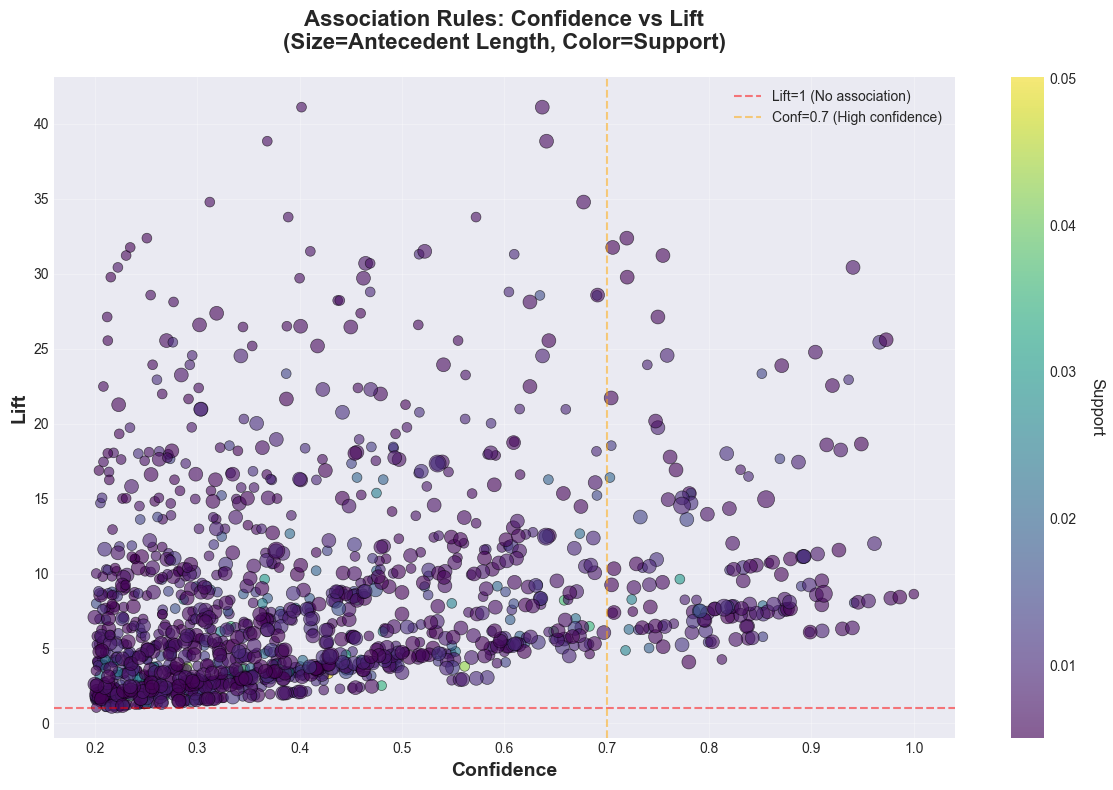

In [200]:
fig = plot_rule_scatter(rules, figsize=(12, 8))
plt.show()

### 2. Rules Network Graph

Network visualization of top association rules showing tag relationships

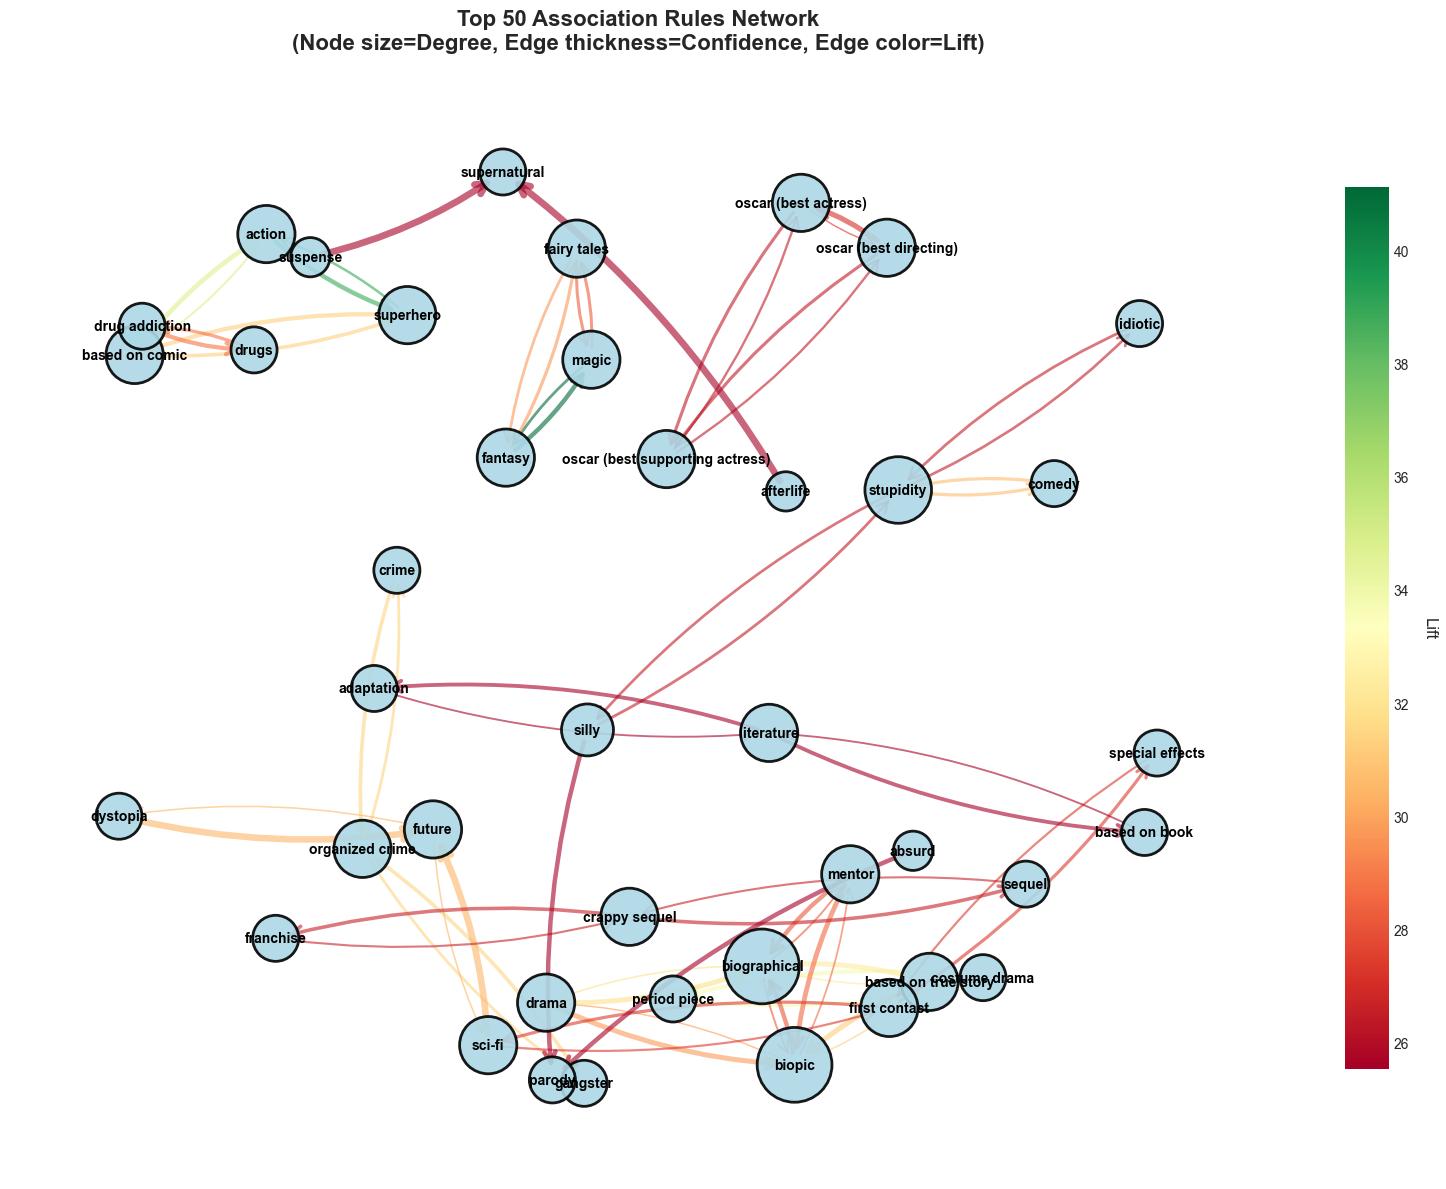

In [202]:
fig = plot_top_rules_network(rules, top_n=50, figsize=(16, 12))
plt.show()

### 3. Tag Co-occurrence Heatmap

Shows which tags frequently appear together in movies

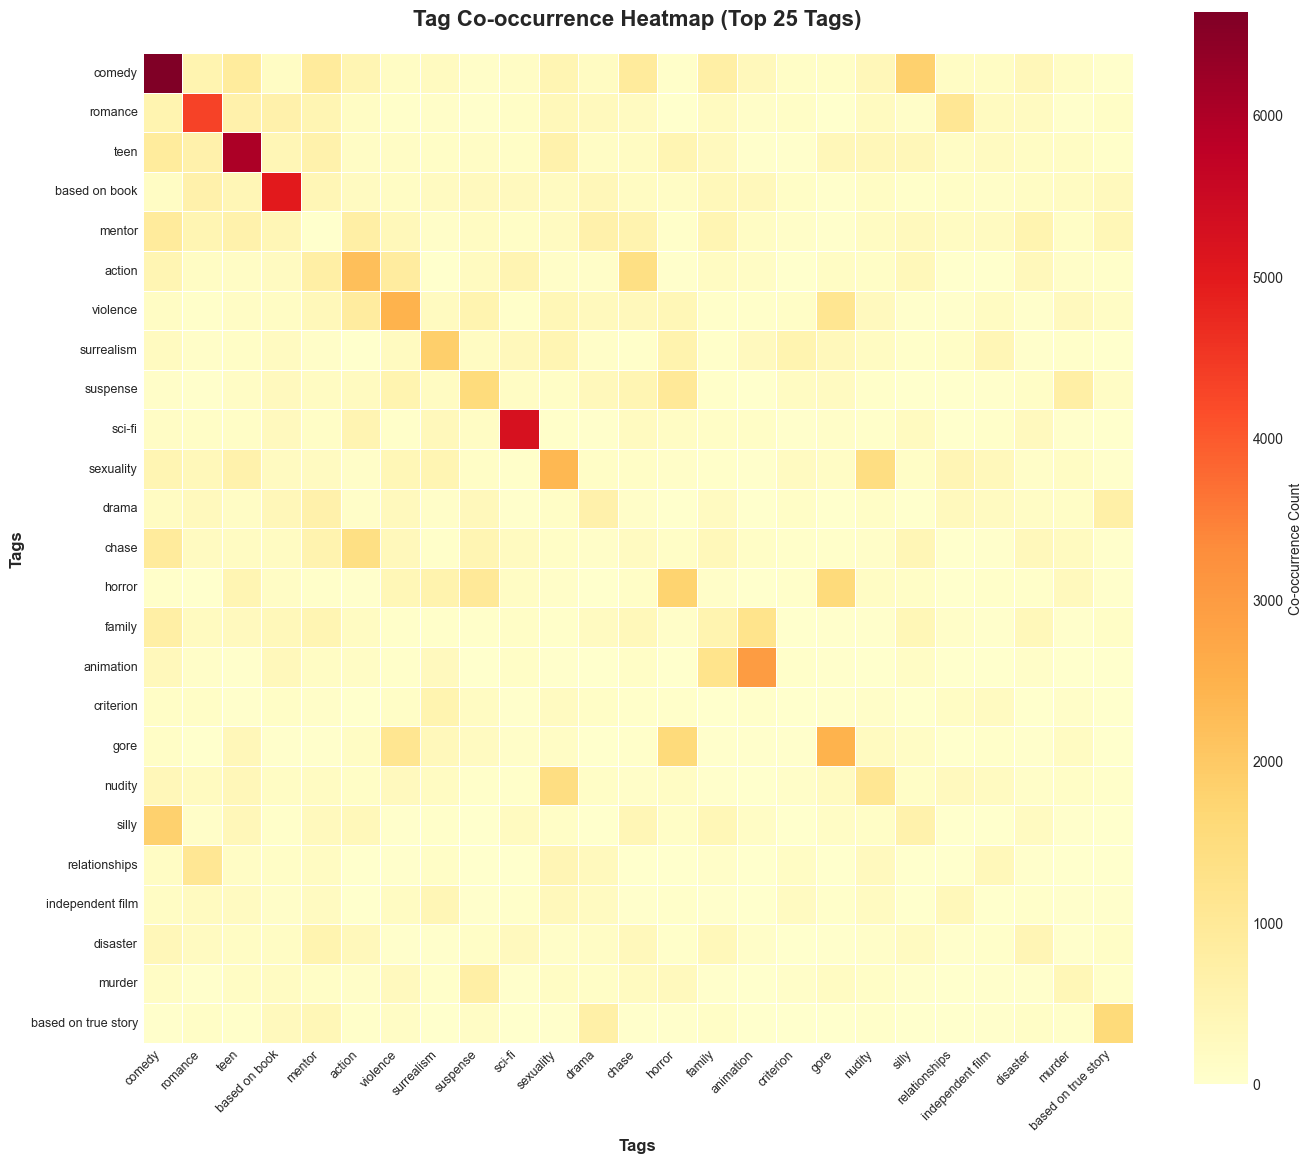

In [203]:
fig = plot_tag_cooccurrence_heatmap(df_transactions, top_n=25, figsize=(14, 12))
plt.show()

### 4. Tag Frequency Distribution

Analyze how tags are distributed across movies

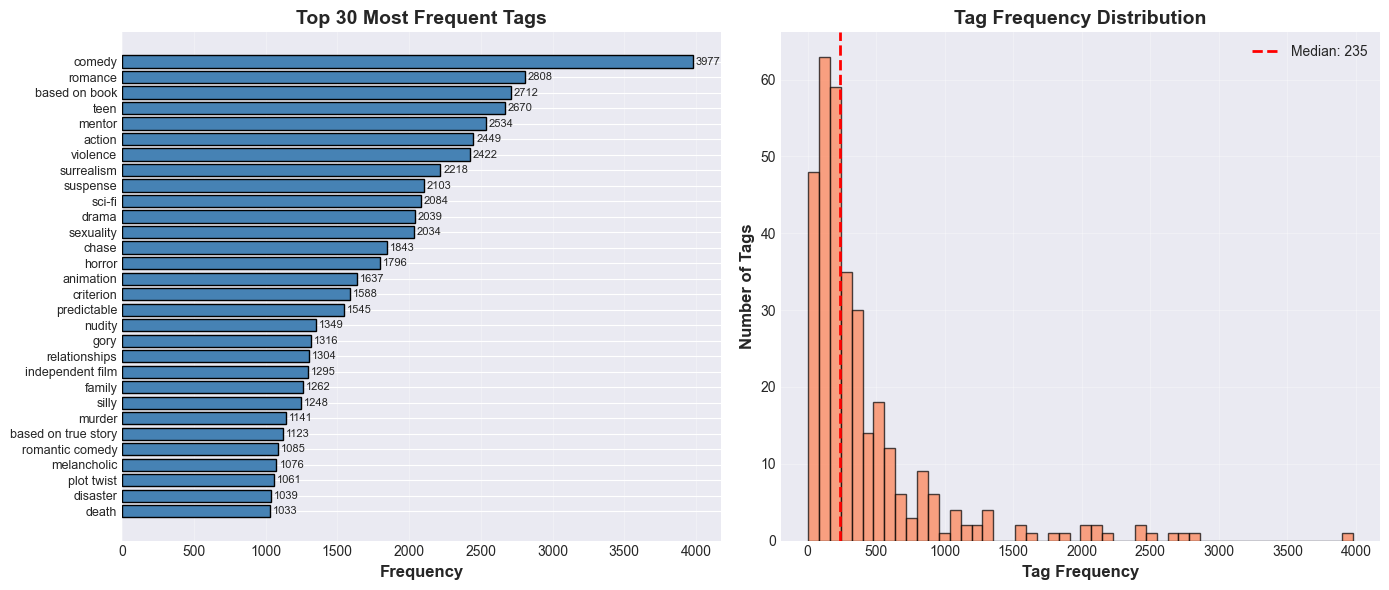

In [187]:
fig = plot_tag_frequency_distribution(df_transactions, figsize=(14, 6))
plt.show()

### 5. Rule Metrics Comparison

Compare the distributions of confidence, lift, and support across all rules

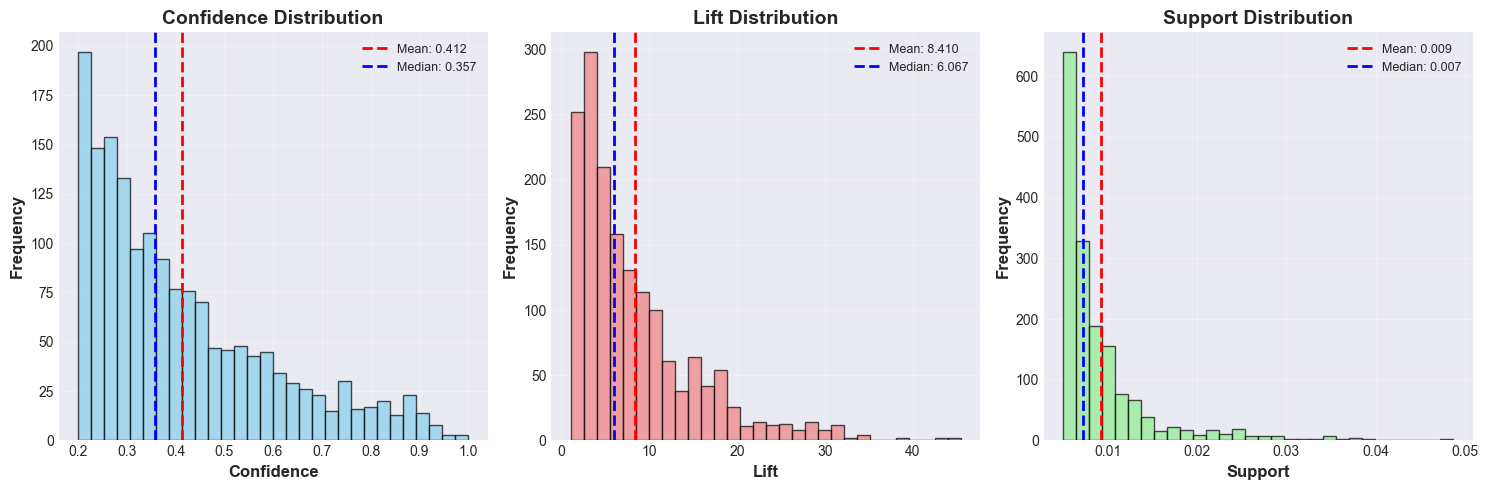

In [188]:
fig = plot_rule_metrics_comparison(rules, figsize=(15, 5))
plt.show()

### 6. Generate All Visualizations

Create all visualizations at once and save them to disk

Generating visualizations...
  1. Rule scatter plot...
  2. Rules network graph (top 50)...
  3. Tag co-occurrence heatmap (top 25)...
  4. Tag frequency distribution...
  5. Rule metrics comparison...
  6. Recommendation comparison...
  7. Diversity analysis...

✅ Generated 7 visualizations
📁 Saved to: ../output/visualizations/
 Generated 7 visualizations
Saved to: ../output/visualizations/


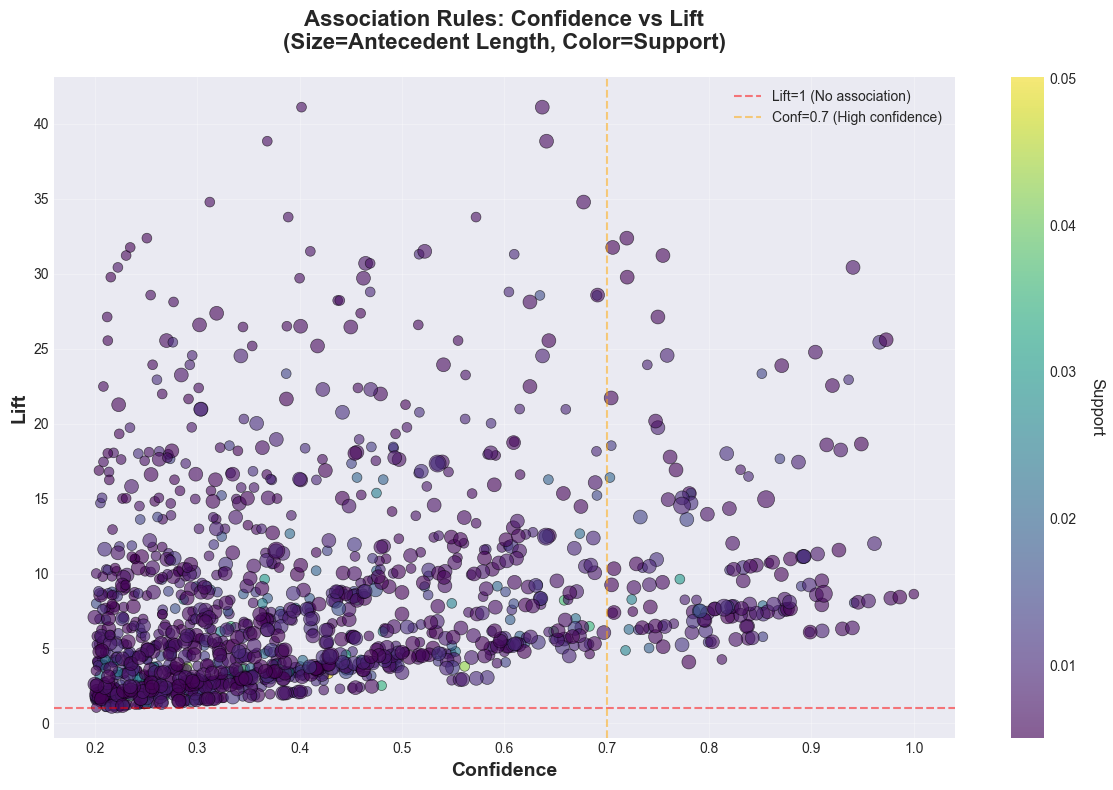

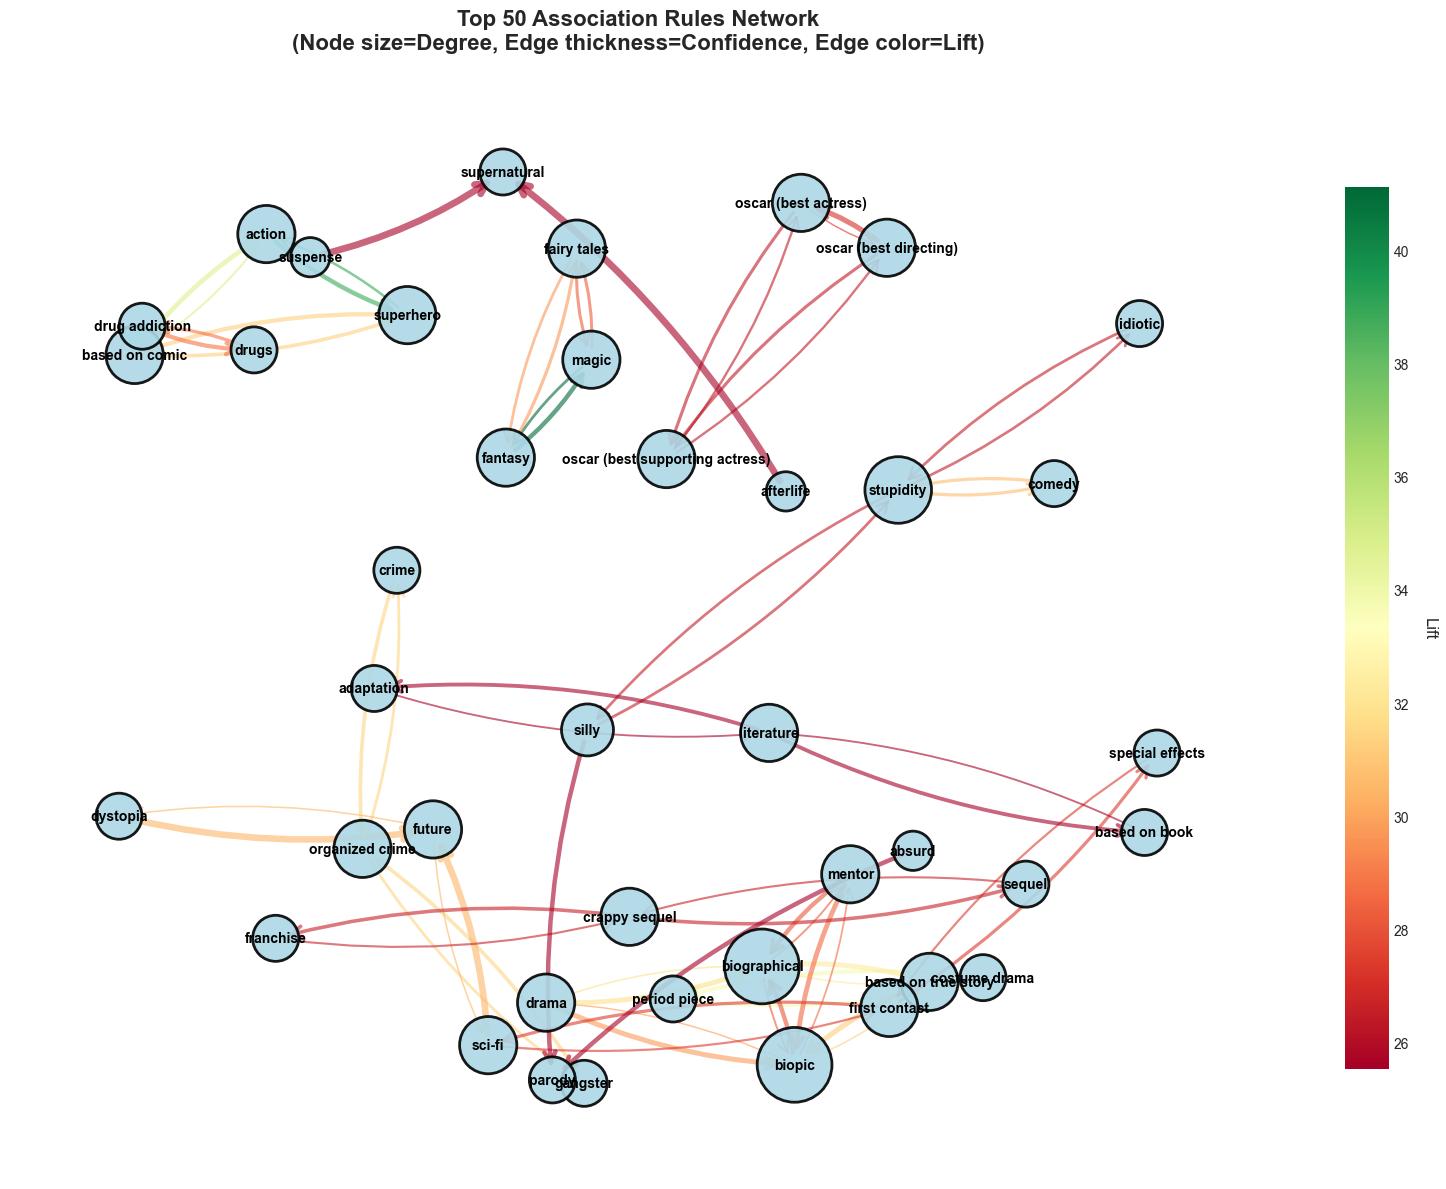

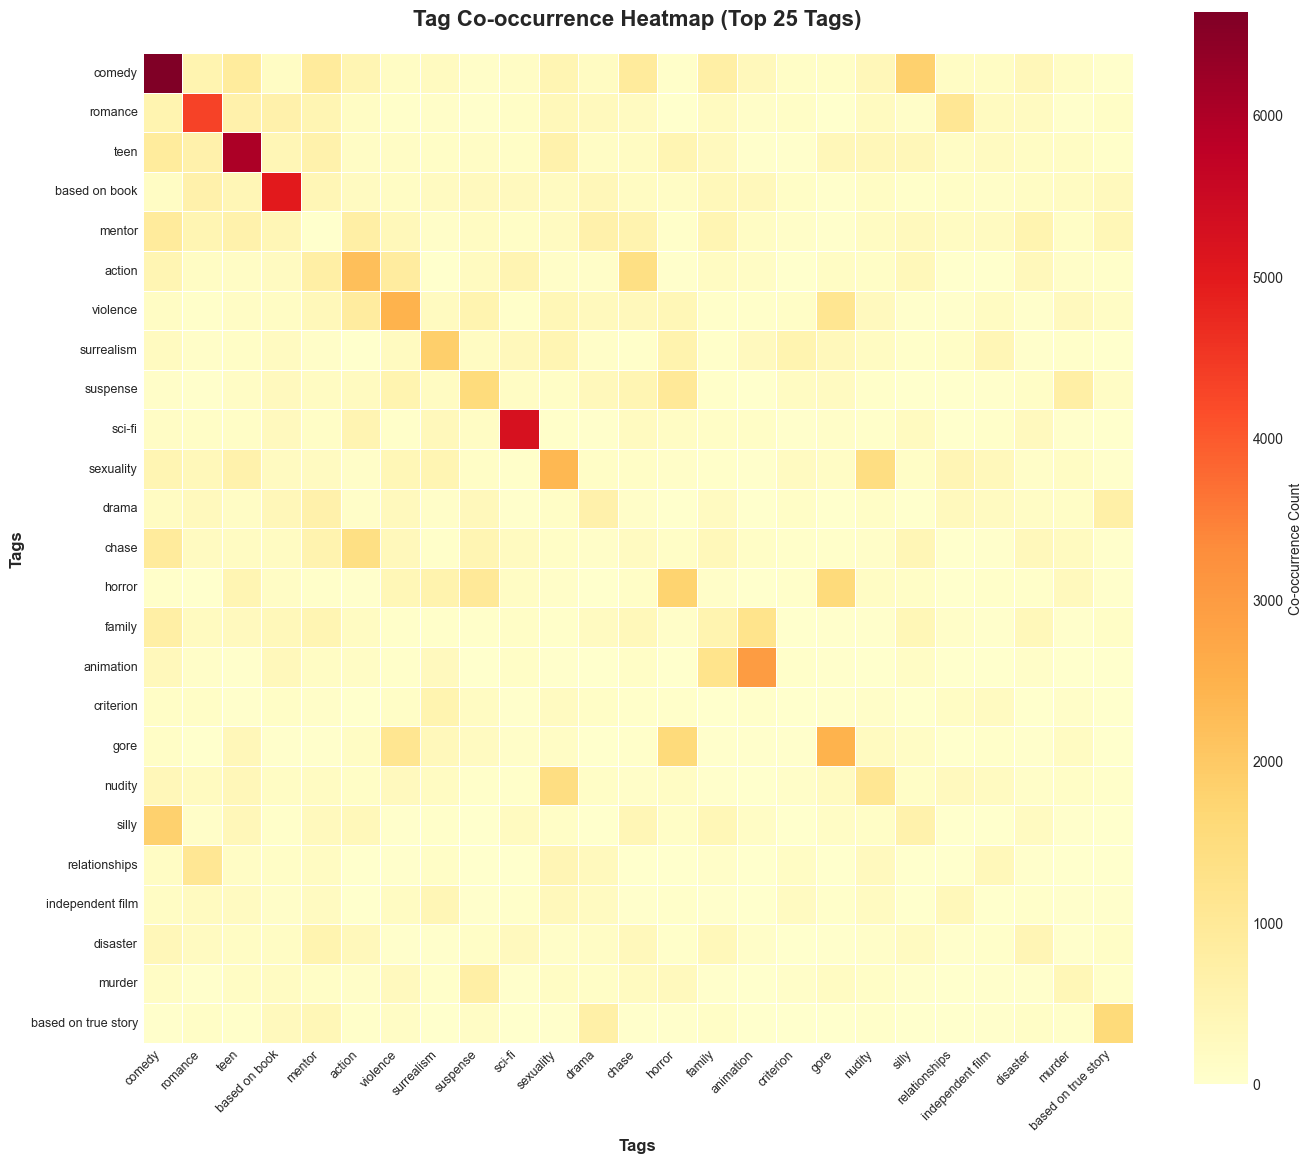

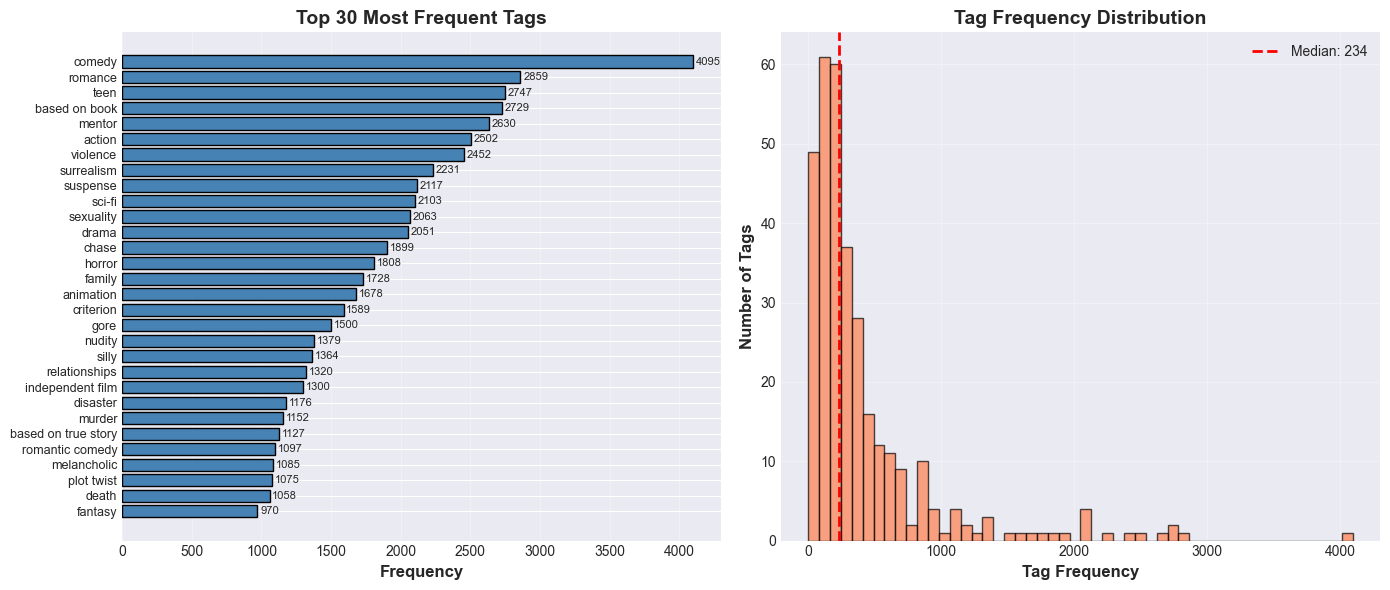

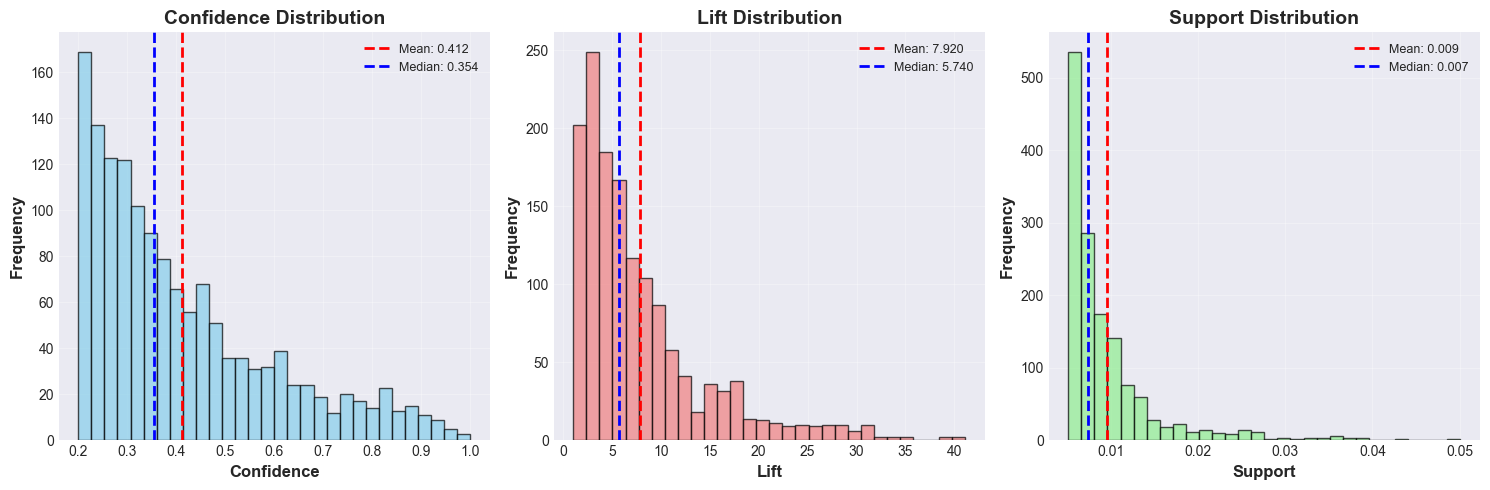

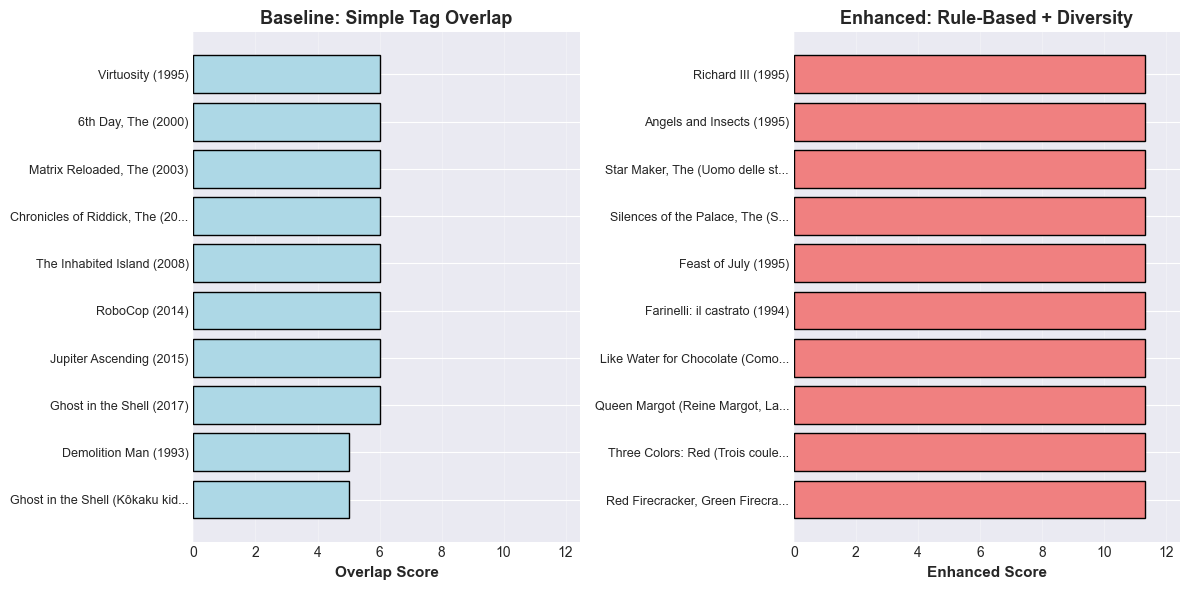

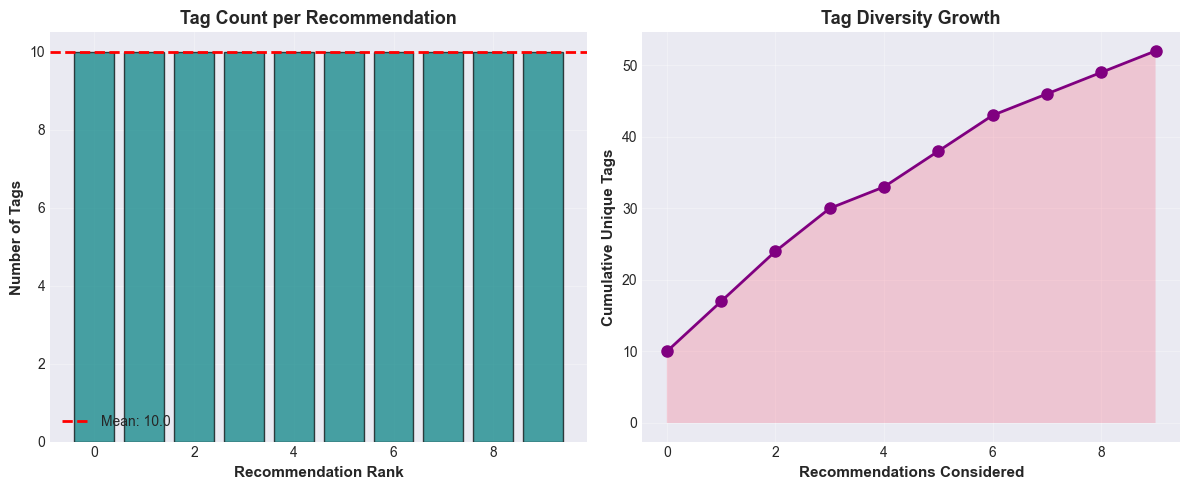

In [205]:
# Generate and save all visualizations
all_figs = create_all_visualizations(
    rules, 
    df_transactions,
    baseline_recs=baseline_recs if 'baseline_recs' in locals() else None,
    enhanced_recs=enhanced_recs if 'enhanced_recs' in locals() else None,
    network_top_n=50,
    heatmap_top_n=25,
    save_dir='../output/visualizations'
)

print(f" Generated {len(all_figs)} visualizations")
print("Saved to: ../output/visualizations/")